## Backtesting for option trading

Dataset loaded ⇒ 2024‑06‑20 15:59 → 2024‑12-20 15:59  (6‑month look‑back, 49,033 rows)


Back‑test: 100%|████████████████████████| 49033/49033 [00:33<00:00, 1484.49it/s]



Results  |  Final equity: $103,108.67   Total P/L: $3,108.67
CAGR: 6.33%   Max DD: $-4,394.26   Sharpe: 0.50
Trades: 31   |   Win rate: 41.9%


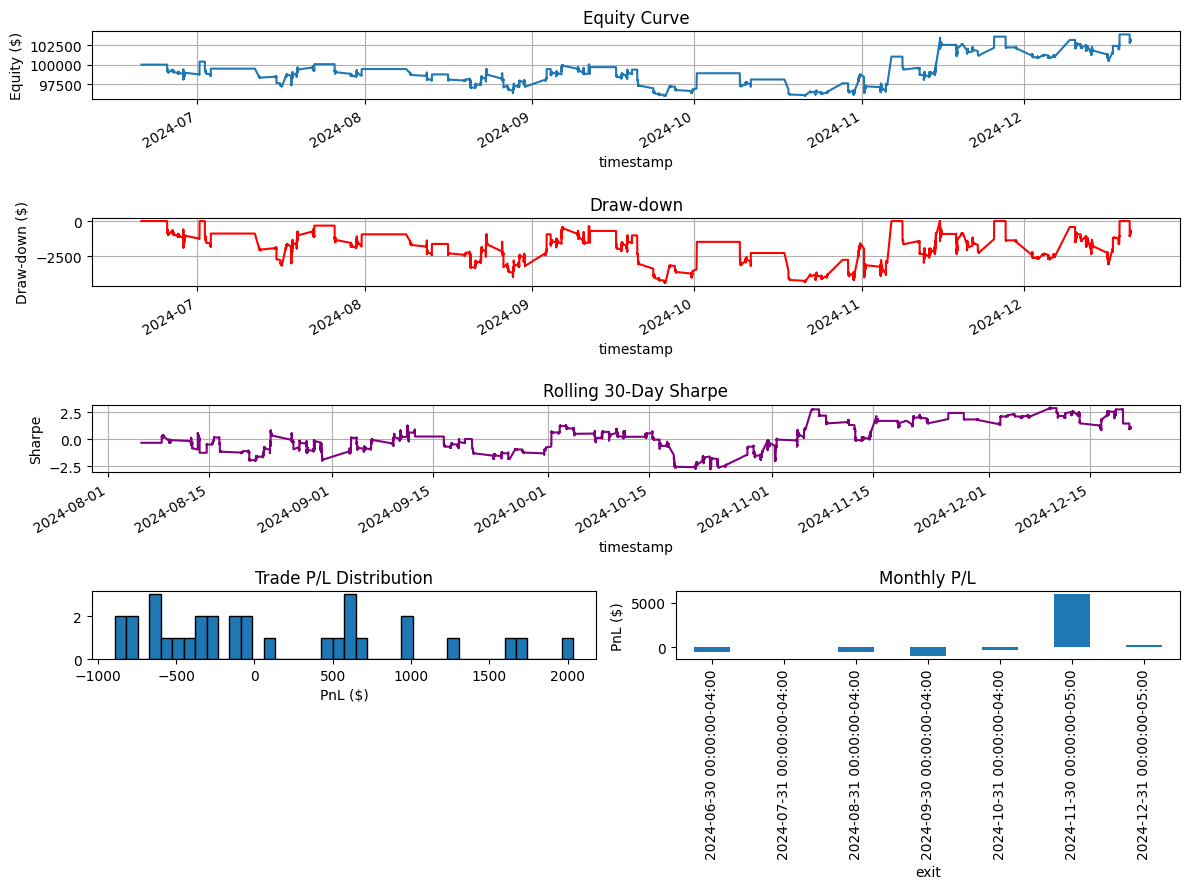

In [1]:
#!/usr/bin/env python3
"""
================================================================================
SPY Gamma‑Exposure Option Back‑tester
================================================================================
Back‑tests two intraday option plays that exploit divergences between **SPY**
price action and **CBOE Gamma‑Exposure (GEX)** data.  The engine consumes
one‑minute bars and prices positions minute‑by‑minute with QuantLib BSM.

Why this script?
----------------
*  **Research‑grade logging & reporting** – every entry/exit is logged; a
   dashboard plots equity, draw‑down, rolling Sharpe, trade histogram and
   monthly P/L.
*  **Realistic micro‑structure** – weekly Friday expiries with ≥ 5 NYSE
   sessions’ notice, rolling realised σ, bidirectional risk caps.
*  **Config‑only runtime tuning** – key parameters (capital, risk, look‑back
   window, etc.) live in the CONFIG section; *no command‑line switches*.

Indicators & Strategy Logic
---------------------------
1. **Price ↑ while Net GEX → negative ⇒ Reversal Put‑Spread**

   | Signal | Expectation | Position |
   |--------|-------------|-----------|
   | Spot above 20‑min SMA **and** Net GEX crosses from ≥ 0 to < 0 | Mean‑revert lower (dealers flip short‑gamma) | +ATM put / –3 % OTM put (weekly) |

2. **Price flat & Abs GEX surge ⇒ Coiled‑Gamma Straddle + Put**

   | Signal | Expectation | Position |
   |--------|-------------|-----------|
   | |30‑min return| < 0.2 % **and** Abs GEX in top 10 % (30‑day look‑back) | “Coiled” volatility, downside bias | ATM straddle + extra 2 % OTM put |

Risk Management
---------------
* **Capital**                      : USD 100 000  
* **Reversal put‑spread**   : ≤ 1 % capital debit  
* **Coiled‑gamma trade**    : ≤ 1.5 % capital debit  
* **Stops / Profits**        : hard SL on spot, 70 % TP, timeouts  
* **Contract multiplier**    : 100 (SPY)

Look‑back Window
----------------
The data fed to the back‑test is clipped to the most‑recent
``LOOKBACK_MONTHS`` calendar months (default = 6).  Change this constant in
CONFIG to widen or narrow the test horizon.

Dataset Columns
---------------
Spot_Open, Spot_High, Spot_Low, Spot_Close, 
open_abs_gex, high_abs_gex, low_abs_gex, close_abs_gex, volume_abs_gex open_net_gex, 
close_net_gex, volume_net_gex PCT_EPS_1mo_Open/Close/High/Low

Dependencies
------------
``pandas ≥ 2.2 · numpy · matplotlib · QuantLib‑Python · tqdm``

Author : ChatGPT demo – Apr 2025  Licence : MIT
================================================================================
"""
from __future__ import annotations

import logging
import pickle
import uuid
import warnings
from dataclasses import dataclass, field
from datetime import date, timedelta
from pathlib import Path
from typing import List, Literal, Optional

import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
from tqdm import tqdm

# ──────────────────────────────────────────────────────────────────────────────
#                                CONFIGURATION
# ──────────────────────────────────────────────────────────────────────────────
DATA_FILE: Path = Path("NetGEX_AbsGEX_EPS(SPY).pickle")

CAPITAL: float = 100_000.0
RISK_PCT_REVERSAL: float = 0.01     # strategy 1
RISK_PCT_COIL: float = 0.015        # strategy 2
CONTRACT_MULT: int = 100            # SPY option multiplier

RISK_FREE: float = 0.05
DIV_YIELD: float = 0.014

LOOKBACK_MONTHS: int = 6            # ←–– back‑test window in months

CAL = ql.UnitedStates(ql.UnitedStates.NYSE)
DAY_COUNT = ql.Actual365Fixed()

LOG_FILE = "backtest.log"
logging.basicConfig(
    filename=LOG_FILE,
    level=logging.INFO,
    format="%(asctime)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

warnings.filterwarnings("ignore", category=DeprecationWarning)

# ──────────────────────────────────────────────────────────────────────────────
#                             QUANTLIB‑HELPER FUNCS
# ──────────────────────────────────────────────────────────────────────────────
def _ql_date(ts: pd.Timestamp) -> ql.Date:
    return ql.Date(ts.day, ts.month, ts.year)


def _flat_curve(ts: pd.Timestamp, rate: float) -> ql.YieldTermStructureHandle:
    return ql.YieldTermStructureHandle(ql.FlatForward(_ql_date(ts), rate, DAY_COUNT))


def bs_price(
    ts: pd.Timestamp,
    expiry: date,
    spot: float,
    strike: float,
    opt_type: Literal["C", "P"],
    vol: float,
) -> float:
    """Black‑Scholes‑Merton option **NPV per share**."""
    ql.Settings.instance().evaluationDate = _ql_date(ts)
    payoff = ql.PlainVanillaPayoff(
        ql.Option.Call if opt_type == "C" else ql.Option.Put, strike
    )
    exercise = ql.EuropeanExercise(_ql_date(pd.Timestamp(expiry)))
    process = ql.BlackScholesMertonProcess(
        ql.QuoteHandle(ql.SimpleQuote(spot)),
        _flat_curve(ts, DIV_YIELD),
        _flat_curve(ts, RISK_FREE),
        ql.BlackVolTermStructureHandle(
            ql.BlackConstantVol(_ql_date(ts), CAL, vol, DAY_COUNT)
        ),
    )
    option = ql.EuropeanOption(payoff, exercise)
    option.setPricingEngine(ql.AnalyticEuropeanEngine(process))
    return option.NPV()


# ──────────────────────────────────────────────────────────────────────────────
#                                EXPIRIES
# ──────────────────────────────────────────────────────────────────────────────
def _next_friday(src: date, offset_weeks: int) -> date:
    friday = src + timedelta(days=(4 - src.weekday()) % 7)
    return friday + timedelta(weeks=offset_weeks)


def choose_expiry(ts: pd.Timestamp, weeks_ahead: int) -> date:
    """
    First Friday at least five NYSE sessions away.
    """
    exp = _next_friday(ts.date(), weeks_ahead)
    while (exp - ts.date()).days < 5 or CAL.isHoliday(_ql_date(pd.Timestamp(exp))):
        exp += timedelta(days=7)
    return exp


# ──────────────────────────────────────────────────────────────────────────────
#                               DATA LOADER
# ──────────────────────────────────────────────────────────────────────────────
def load_dataset(path: Path, months_lookback: int = LOOKBACK_MONTHS) -> pd.DataFrame:
    """
    Load the minute‑bar pickle, derive indicators, then clip to the most recent
    ``months_lookback`` months.
    """
    with open(path, "rb") as f:
        df: pd.DataFrame = pickle.load(f)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Data must have a pandas `DateTimeIndex`.")
    df.sort_index(inplace=True)

    # ----- realised volatility & study columns
    log_ret = np.log(df["Spot_Close"]).diff()
    df["sigma"] = (
        log_ret.rolling(390, min_periods=200).std() * np.sqrt(252 * 390)
    ).bfill().clip(lower=0.05)
    df["MA20"] = df["Spot_Close"].rolling(20, min_periods=20).mean()
    df["net_cross"] = (df["close_net_gex"].shift(1) >= 0) & (df["close_net_gex"] < 0)

    abs_gex = df["close_abs_gex"]
    df["abs_spike"] = abs_gex > abs_gex.rolling("30D", min_periods=60).quantile(0.9)
    df["flat_price"] = df["Spot_Close"].pct_change(30).abs() < 0.002

    # ----- clip window
    cutoff = df.index[-1] - pd.DateOffset(months=months_lookback)
    df = df.loc[df.index >= cutoff]

    start, end = df.index[0], df.index[-1]
    print(
        f"Dataset loaded ⇒ {start:%Y‑%m‑%d %H:%M} → {end:%Y‑%m-%d %H:%M}  "
        f"({months_lookback}‑month look‑back, {len(df):,} rows)"
    )
    return df


# ──────────────────────────────────────────────────────────────────────────────
#                           TRADE DATA STRUCTURES
# ──────────────────────────────────────────────────────────────────────────────
@dataclass
class Leg:
    opt_type: Literal["C", "P"]
    strike: float
    qty: int  # +long / –short


@dataclass
class Position:
    """
    Container for multi‑leg option trades; handles MTM & exit logic.
    """

    tag: Literal["REVERSAL", "COIL"]
    entry: pd.Timestamp
    expiry: date
    legs: List[Leg]
    contracts: int
    debit: float
    entry_price: float
    stop_price: float
    max_hold: timedelta
    uid: str = field(default_factory=lambda: uuid.uuid4().hex[:8])

    status: Literal["open", "closed"] = "open"
    exit: Optional[pd.Timestamp] = None
    pnl: float = 0.0
    exit_reason: str = ""

    def mark_to_market(self, ts: pd.Timestamp, spot: float, vol: float) -> float:
        v = sum(
            bs_price(ts, self.expiry, spot, leg.strike, leg.opt_type, vol)
            * CONTRACT_MULT
            * leg.qty
            for leg in self.legs
        )
        return v * self.contracts

    def maybe_close(self, ts: pd.Timestamp, spot: float, vol: float) -> None:
        if self.status == "closed":
            return

        held = ts - self.entry
        mtm = self.mark_to_market(ts, spot, vol)

        if self.tag == "REVERSAL":
            width = abs(self.legs[0].strike - self.legs[1].strike) * CONTRACT_MULT
            tgt = self.debit + 0.7 * width * self.contracts
        else:
            tgt = self.debit * 1.7

        if mtm >= tgt:
            reason = "TP"
        elif spot > self.stop_price:
            reason = "SL"
        elif held >= self.max_hold:
            reason = "TIME"
        else:
            return

        self.status = "closed"
        self.exit = ts
        self.pnl = mtm - self.debit
        self.exit_reason = reason
        logging.info(
            f"EXIT | {self.tag} | id {self.uid} | {ts} | pnl {self.pnl:.2f} | {reason}"
        )


# ──────────────────────────────────────────────────────────────────────────────
#                              BACK‑TEST ENGINE
# ──────────────────────────────────────────────────────────────────────────────
def contracts_for_risk(premium: float, risk_pct: float) -> int:
    """Whole‑contract sizing so debit ≤ ``risk_pct × CAPITAL``."""
    return int((CAPITAL * risk_pct) // premium)


def backtest(df: pd.DataFrame) -> tuple[pd.DataFrame, List[Position]]:
    cash = CAPITAL
    open_pos: List[Position] = []
    closed_pos: List[Position] = []
    equity_log: list[dict[str, float]] = []

    for row in tqdm(df.itertuples(), total=len(df), ncols=80, desc="Back‑test"):
        ts = row.Index
        spot = row.Spot_Close
        vol = row.sigma

        # exits
        for pos in list(open_pos):
            pos.maybe_close(ts, spot, vol)
            if pos.status == "closed":
                cash += pos.pnl + pos.debit
                open_pos.remove(pos)
                closed_pos.append(pos)

        # Reversal put‑spread
        if row.net_cross and spot > row.MA20 and not any(p.tag == "REVERSAL" for p in open_pos):
            exp = choose_expiry(ts, 1)
            k_long, k_short = round(spot), round(spot * 0.97)
            prem_long = bs_price(ts, exp, spot, k_long, "P", vol) * CONTRACT_MULT
            prem_short = bs_price(ts, exp, spot, k_short, "P", vol) * CONTRACT_MULT
            prem_each = prem_long - prem_short
            qty = contracts_for_risk(prem_each, RISK_PCT_REVERSAL)
            if qty:
                pos = Position(
                    tag="REVERSAL",
                    entry=ts,
                    expiry=exp,
                    legs=[Leg("P", k_long, +1), Leg("P", k_short, -1)],
                    contracts=qty,
                    debit=prem_each * qty,
                    entry_price=spot,
                    stop_price=spot * 1.01,
                    max_hold=timedelta(days=7),
                )
                open_pos.append(pos)
                cash -= pos.debit
                logging.info(
                    f"ENTRY | REVERSAL | id {pos.uid} | {ts} | qty {qty} | debit {pos.debit:.2f} "
                    f"| strikes {k_long}/{k_short} | σ {vol:.2f}"
                )

        # Coiled‑gamma trade
        if row.flat_price and row.abs_spike and not any(p.tag == "COIL" for p in open_pos):
            exp = choose_expiry(ts, 2)
            k_atm, k_put = round(spot), round(spot * 0.98)
            prem_each = (
                bs_price(ts, exp, spot, k_atm, "C", vol)
                + bs_price(ts, exp, spot, k_atm, "P", vol)
                + bs_price(ts, exp, spot, k_put, "P", vol)
            ) * CONTRACT_MULT
            qty = contracts_for_risk(prem_each, RISK_PCT_COIL)
            if qty:
                pos = Position(
                    tag="COIL",
                    entry=ts,
                    expiry=exp,
                    legs=[
                        Leg("C", k_atm, +1),
                        Leg("P", k_atm, +1),
                        Leg("P", k_put, +1),
                    ],
                    contracts=qty,
                    debit=prem_each * qty,
                    entry_price=spot,
                    stop_price=spot * 1.02,
                    max_hold=timedelta(days=10),
                )
                open_pos.append(pos)
                cash -= pos.debit
                logging.info(
                    f"ENTRY | COIL | id {pos.uid} | {ts} | qty {qty} | debit {pos.debit:.2f} "
                    f"| strikes {k_atm}/{k_put} | σ {vol:.2f}"
                )

        # mark‑to‑market
        mtm_open = sum(p.mark_to_market(ts, spot, vol) - p.debit for p in open_pos)
        equity_log.append({"timestamp": ts, "equity": cash + mtm_open})

    return pd.DataFrame(equity_log).set_index("timestamp"), closed_pos


# ──────────────────────────────────────────────────────────────────────────────
#                           PERFORMANCE METRICS
# ──────────────────────────────────────────────────────────────────────────────
def perf_stats(eq: pd.Series) -> dict[str, float]:
    ret = eq.pct_change().dropna()
    years = len(ret) / (252 * 390)
    cagr = (eq.iloc[-1] / eq.iloc[0]) ** (1 / years) - 1 if years else 0.0
    dd = (eq - eq.cummax()).min()
    sharpe = ret.mean() / ret.std() * np.sqrt(252 * 390) if ret.std() else 0.0
    return {"CAGR": cagr, "MaxDD": dd, "Sharpe": sharpe}


def dashboard(eq: pd.Series, trades: List[Position]) -> None:
    fig = plt.figure(figsize=(12, 9))
    gs = fig.add_gridspec(4, 2)
    ax_eq = fig.add_subplot(gs[0, :])
    ax_dd = fig.add_subplot(gs[1, :])
    ax_sh = fig.add_subplot(gs[2, :])
    ax_hist = fig.add_subplot(gs[3, 0])
    ax_month = fig.add_subplot(gs[3, 1])

    eq.plot(ax=ax_eq, title="Equity Curve", grid=True)
    ax_eq.set_ylabel("Equity ($)")
    dd = eq - eq.cummax()
    dd.plot(ax=ax_dd, color="r", title="Draw‑down", grid=True)
    ax_dd.set_ylabel("Draw‑down ($)")

    roll_sh = (
        eq.pct_change()
        .rolling(30 * 390)
        .apply(lambda x: x.mean() / x.std() * np.sqrt(252 * 390) if x.std() else 0.0)
    )
    roll_sh.plot(ax=ax_sh, color="purple", title="Rolling 30‑Day Sharpe", grid=True)
    ax_sh.set_ylabel("Sharpe")

    pnl = [t.pnl for t in trades]
    ax_hist.hist(pnl, bins=40, edgecolor="black")
    ax_hist.set_title("Trade P/L Distribution")
    ax_hist.set_xlabel("PnL ($)")

    monthly = (
        pd.DataFrame({"pnl": pnl, "exit": [t.exit for t in trades]})
        .set_index("exit")
        .resample("ME", label="right", closed="right")
        .sum()
    )
    monthly.plot.bar(ax=ax_month, legend=False)
    ax_month.set_title("Monthly P/L")
    ax_month.set_ylabel("PnL ($)")
    plt.tight_layout()
    plt.show()


# ──────────────────────────────────────────────────────────────────────────────
#                                    MAIN
# ──────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    df_all = load_dataset(DATA_FILE, months_lookback=LOOKBACK_MONTHS)
    equity_df, trades_done = backtest(df_all)
    equity_df.to_csv("equity_curve.csv")

    stats = perf_stats(equity_df["equity"])
    final_eq = equity_df["equity"].iloc[-1]
    print(
        f"\nResults  |  Final equity: ${final_eq:,.2f}   "
        f"Total P/L: ${final_eq - CAPITAL:,.2f}"
    )
    print(
        f"CAGR: {stats['CAGR']:.2%}   Max DD: ${stats['MaxDD']:,.2f}   "
        f"Sharpe: {stats['Sharpe']:.2f}"
    )
    if trades_done:
        win_rate = sum(t.pnl > 0 for t in trades_done) / len(trades_done) * 100
        print(f"Trades: {len(trades_done)}   |   Win rate: {win_rate:.1f}%")
    else:
        print("No trades executed.")

    dashboard(equity_df["equity"], trades_done)
